In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rand_number_generator(x):
    num = (572*x)%16381
    return num

def rand_angles(N, seed):
    angles = np.zeros(N)
    for i in range(N):
        if i == 0:
            value = rand_number_generator(seed)
        else:
            value = rand_number_generator(value)
        angles[i] = value
    
    angles = (angles/16381)*2*np.pi        
    return angles

In [3]:
#a 2d random walk
def walk(steps, seed):
    angles = rand_angles(steps, seed)
    pos = np.zeros((steps,2))
    for i in range(1,steps):
        pos[i,:] = pos[i-1,:] + [np.cos(angles[i]), np.sin(angles[i])]
    return pos

In [4]:
def walk_plotter(walk):
    plt.scatter(walk[:,0], walk[:,1])
    plt.plot(walk[:,0], walk[:,1], color='k')
    plt.show()

In [5]:
def rms(walk):
    return np.sqrt(np.mean([position[0]**2+position[1]**2 for position in walk]))

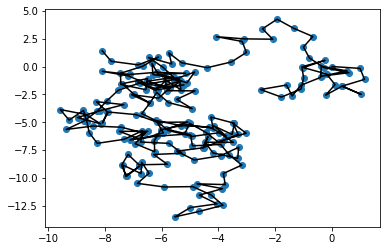

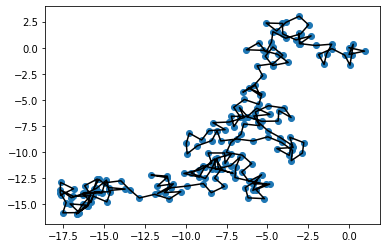

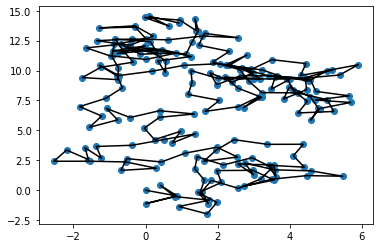

RMS for 500 walks of 200 steps is:  9.140400837751091


In [7]:
walks = 500
steps = 200
dimensions = 2

#simulate 500 random walks of 200 steps in 2 dimensions
strolls = np.zeros((walks, steps, dimensions))
for i in range(walks):
    #using i+1 as seed
    #to get different set of walks, use seed = f(i)
    #we took f(i) = i+1
    strolls[i,:,:] = walk(steps, i+1)

#Plotting first 3 walks
for i in range(3):
    walk_plotter(strolls[i])
    
rmses = [rms(walk) for walk in strolls]
rms_final = np.mean(rmses)
print("RMS for 500 walks of 200 steps is: ", rms_final)